In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

Using TensorFlow backend.


In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [3]:
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 2
batch_size = 32

In [4]:
train_path = 'large_files/fruits-360-small/Training'
valid_path = 'large_files/fruits-360-small/Validation'


In [5]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

print(len(image_files))


3827


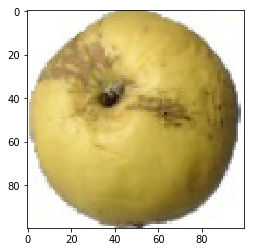

In [6]:
# look at an image for fun
img=image.load_img(np.random.choice(image_files))
img=image.img_to_array(img).astype('uint8')
#plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.imshow(img)
plt.show()

In [7]:
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(100,100,3))

In [8]:
for layer in vgg.layers:
    layer.trainable =False

In [9]:
x=Flatten()(vgg.output)
prediction=Dense(len(folders),activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prediction)

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [11]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
gen=ImageDataGenerator(rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.2,horizontal_flip=True,vertical_flip=True,preprocessing_function=preprocess_input)

In [13]:
test_gen=gen.flow_from_directory(valid_path,target_size=IMAGE_SIZE)

Found 1285 images belonging to 8 classes.


In [14]:
print(test_gen.classes[1284])

7


In [15]:
labels = [None] * len(test_gen.class_indices)
print(labels)
for k, v in test_gen.class_indices.items():
  labels[v] = k
print(labels[0])

[None, None, None, None, None, None, None, None]
Apple Golden 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.60827 max: 151.061
[0. 1. 0. 0. 0. 0. 0. 0.]


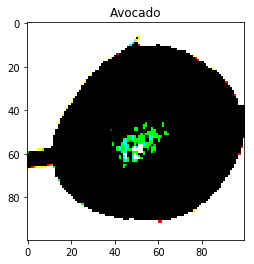

In [16]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  print(y[0])
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [17]:
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3827 images belonging to 8 classes.
Found 1285 images belonging to 8 classes.


In [18]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/2
119/119 [==============================] - 844s 7s/step - loss: 3.1015 - acc: 0.7889 - val_loss: 2.1109 - val_acc: 0.8553
Epoch 2/2
119/119 [==============================] - 831s 7s/step - loss: 1.9870 - acc: 0.8732 - val_loss: 1.9722 - val_acc: 0.8755


In [19]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

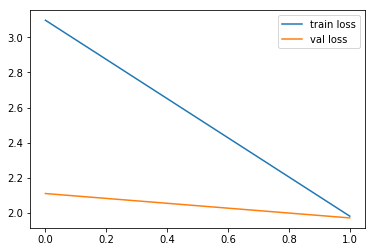

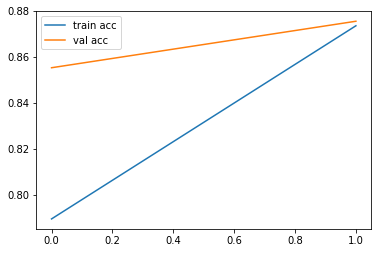

In [25]:
# loss
#print(r.history)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
STEP_SIZE_TEST=valid_generator.n//test_generator.batch_size
valid_generator.reset()
pred=model.predict_generator(valid_generator,
steps=STEP_SIZE_TEST,
verbose=1)